# Calculate metrics using climpred

---

Now that all of our model and observational data is ready for analysis, we can run this notebook and calculate various metrics using climpred across all models and seasons and compare how they do. It is recommended that you use `dask` to run this notebook as we are looking at geospatial data and making maps. You can start up a `dask` cluster by running the notebook `cluster.ipynb` and copying the Scheduler tcp number into this notebook.

In [1]:
import cftime
import numpy as np
import xarray as xr
import pandas as pd
xr.set_options(keep_attrs=True)
import climpred
import intake
from tqdm import tqdm
import dask.array as da
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import xskillscore as xs
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image 
from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})


In [2]:
# Additional schnickschnack for state-dependence
#conda install -c conda-forge xesmf
#! pip install intake-xarray
#conda install -c conda-forge regionmask
#!pip install intake-geopandas
#!pip install intake_geopandas

- Make sure you have copied the correct tcp here from the `cluster.ipynb` notebook

In [5]:
client = Client("tcp://10.12.206.51:35905")

## Here is where you choose your variable, metric and start/end time.

In [6]:
variable = "t2m" #can be t2m, tp, gh_500
metric = "rps" #can be rps, rmse, acc
data = "anom" # can be anom, raw
lead = "biweekly" #biweekly or daily
area = "geospatial"
start = "1999-01-01"
#end = "2021-12-31" 
end = "2001-12-31"
models = ["ECMWF","CESM2","NCEP"] #this notebook uses all three of these models

In [7]:
# Here we are just setting options for the different metrics and mapping.
if metric == "acc":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="RdBu_r" #options for maps
elif metric=="rmse":
    comp="e2o"; dim="init"; ens="ensmean" #options for metrics
    cmap="viridis" #options for maps
elif metric=="rps":
    comp="m2o"; dim=["init","member"]; ens="" #options for metrics
    cmap="viridis" #options for maps

## Now we read in and load the data into `dask`

We are using the intake catalog to find the data and load it up. Make sure you have the file `ASP_data_catalog.yml` in your local directory. Or you can find it here: `/glade/campaign/mmm/c3we/jaye/S2S_zarr/`

We have an `if` statement here telling us to load in category_edge files, only if our metric of choice is `rps`

In [8]:
cat = intake.open_catalog('ASP_data_catalog.yml')

In [9]:
hinds = {}
for m in models:
    hinds[m] = cat[m](data=data, lead=lead, dim=area).to_dask().astype('float32')
verif = cat['OBS'](data=data, lead=lead, dim=area).to_dask().astype('float32')

In [10]:
verif

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 8022)
Coordinates:
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * time     (time) object 1999-01-01 00:00:00 ... 2020-12-17 00:00:00
Data variables:
    gh_500   (time, lat, lon) float32 dask.array<chunksize=(8022, 121, 240), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8022, 121, 240), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(8022, 121, 240), meta=np.ndarray>

In [11]:
if metric == "rps":
    hinds_edges = {}
    for m in models:
        hinds_edges[m] = cat['cat_edges'](data=data, model=m, lead=lead, dim=area).to_dask().astype('float32') \
                         .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lead": -1, "lon": 60}).persist()
    verif_edges = cat['cat_edges'](data='anom', model='OBS', lead='biweekly', dim='geospatial').to_dask().astype('float32') \
                  .chunk({"category_edge": -1, "dayofyear": -1, "lat": 45, "lon": 60}).persist()

- All of the model data is now loaded into a dictionary so that we can have them all together for comparison purposes.

In [12]:
# is seasonal data available for all models and rechunk
for h in hinds:
    print(hinds[h].init.dt.season.to_index().unique(), 'freq =',hinds[h].init.to_index().freq) # freq would show weekly but calendar conversion breaks this
    hinds[h] = hinds[h].chunk({"member": "auto", "init": -1, "lead": "auto", "lat": 45, "lon": 60}).persist()
    hinds[h] = hinds[h].sel(init=slice(start,end))
verif = verif.sel(time=slice(start,end))
verif = verif.chunk({"time": -1, "lat": 45, "lon": 60})

Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None
Index(['DJF', 'MAM', 'JJA', 'SON'], dtype='object', name='init') freq = None


In [13]:
from datetime import datetime
verif.time

<xarray.DataArray 'time' (time: 1096)>
array([cftime.DatetimeProlepticGregorian(1999, 1, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeProlepticGregorian(1999, 1, 2, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeProlepticGregorian(1999, 1, 3, 0, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeProlepticGregorian(2001, 12, 29, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeProlepticGregorian(2001, 12, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeProlepticGregorian(2001, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1999-01-01 00:00:00 ... 2001-12-31 00:00:00
Attributes:
    avg_period:          0000-00-01 00:00:00
    axis:                T
    coordinate_defines:  start
    delta_t:             0000-00-01 00:00:00
    long_name:           Time
    standard_name:       time

In [14]:
clim= xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/OBS.climatology.biweekly.geospatial.zarr")
clim

<xarray.Dataset>
Dimensions:    (dayofyear: 352, lat: 121, lon: 240)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 346 347 348 349 350 351 352
  * lat        (lat) float64 90.0 88.5 87.0 85.5 ... -85.5 -87.0 -88.5 -90.0
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
Data variables:
    gh_500     (dayofyear, lat, lon) float64 dask.array<chunksize=(352, 121, 240), meta=np.ndarray>
    t2m        (dayofyear, lat, lon) float64 dask.array<chunksize=(352, 121, 240), meta=np.ndarray>
    tp         (dayofyear, lat, lon) float64 dask.array<chunksize=(352, 121, 240), meta=np.ndarray>

In [15]:
# http://indico.ictp.it/event/a09161/session/29/contribution/17/material/0/0.pdf page 15

In [16]:
#verif2["init"] = [cftime.DatetimeProlepticGregorian(pd.DatetimeIndex([d]).year[0], pd.DatetimeIndex([d]).month[0], pd.DatetimeIndex([d]).day[0]) for d in clim.time.values]    

In [17]:
#https://renkulab.io/gitlab/aaron.spring/s2s-ai-competition-bootstrap/-/blob/master/notebooks/verification_RPSS.ipynb
#rps_benchmark = xs.rps(observations_terciled, benchmark_forecasts_terciled, category_edges=None, dim=['forecast_reference_time']).compute()

In [18]:
# Does not make sense since clim deterministic
#%time clim_edges = clim.quantile(q=[1./3.,2./3.],dim='dayofyear', skipna=True).rename({'quantile':'category_edge'}).astype('float32').compute()

In [19]:
clim

<xarray.Dataset>
Dimensions:    (dayofyear: 352, lat: 121, lon: 240)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 346 347 348 349 350 351 352
  * lat        (lat) float64 90.0 88.5 87.0 85.5 ... -85.5 -87.0 -88.5 -90.0
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
Data variables:
    gh_500     (dayofyear, lat, lon) float64 dask.array<chunksize=(352, 121, 240), meta=np.ndarray>
    t2m        (dayofyear, lat, lon) float64 dask.array<chunksize=(352, 121, 240), meta=np.ndarray>
    tp         (dayofyear, lat, lon) float64 dask.array<chunksize=(352, 121, 240), meta=np.ndarray>

In [20]:
verif

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 1096)
Coordinates:
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * time     (time) object 1999-01-01 00:00:00 ... 2001-12-31 00:00:00
Data variables:
    gh_500   (time, lat, lon) float32 dask.array<chunksize=(1096, 45, 60), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1096, 45, 60), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(1096, 45, 60), meta=np.ndarray>

In [21]:
#f=clim.t2m.isel(dayofyear=30)
#f.plot()

In [22]:
verif_edges

<xarray.Dataset>
Dimensions:        (category_edge: 2, dayofyear: 366, lat: 121, lon: 240)
Coordinates:
  * category_edge  (category_edge) float64 0.3333 0.6667
  * dayofyear      (dayofyear) int64 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
  * lat            (lat) float64 90.0 88.5 87.0 85.5 ... -85.5 -87.0 -88.5 -90.0
  * lon            (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
Data variables:
    gh_500         (dayofyear, category_edge, lat, lon) float32 dask.array<chunksize=(366, 2, 45, 60), meta=np.ndarray>
    t2m            (dayofyear, category_edge, lat, lon) float32 dask.array<chunksize=(366, 2, 45, 60), meta=np.ndarray>
    tp             (dayofyear, category_edge, lat, lon) float32 dask.array<chunksize=(366, 2, 45, 60), meta=np.ndarray>

<xarray.DataArray 't2m' (category_edge: 2, lat: 121, lon: 240)>
dask.array<getitem, shape=(2, 121, 240), dtype=float32, chunksize=(2, 45, 60), chunktype=numpy.ndarray>
Coordinates:
  * category_edge  (category_edge) float64 0.3333 0.6667
    dayofyear      int64 32
  * lat            (lat) float64 90.0 88.5 87.0 85.5 ... -85.5 -87.0 -88.5 -90.0
  * lon            (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
Attributes: (12/13)
    actual_range:  [-79.78372955322266, 24.409759521484375]
    avg_period:    0000-00-01 00:00:00
    cell_methods:  time: mean
    comments:      GTS data and is gridded using the Shepard Algorithm
    dataset:       CPC Global Temperature
    level_desc:    Surface
    ...            ...
    max_period:    6z to 6z
    parent_stat:   Other
    statistic:     Maximum
    units:         degC
    valid_range:   [-90.0, 50.0]
    var_desc:      Average Temperature

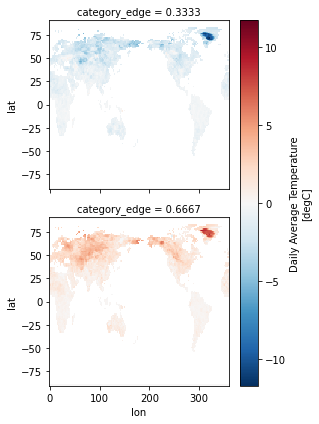

In [23]:
o=verif_edges.t2m.isel(dayofyear=31)
o.plot(row='category_edge')
o

In [25]:
verif1=verif.t2m
clim1=clim.t2m
verif_edges1=verif_edges.t2m

In [26]:
clim1=clim1.expand_dims(member=1)
clim1

<xarray.DataArray 't2m' (member: 1, dayofyear: 352, lat: 121, lon: 240)>
dask.array<broadcast_to, shape=(1, 352, 121, 240), dtype=float64, chunksize=(1, 352, 121, 240), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 346 347 348 349 350 351 352
  * lat        (lat) float64 90.0 88.5 87.0 85.5 ... -85.5 -87.0 -88.5 -90.0
  * lon        (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 354.0 355.5 357.0 358.5
Dimensions without coordinates: member
Attributes: (12/13)
    actual_range:  [-79.78372955322266, 24.409759521484375]
    avg_period:    0000-00-01 00:00:00
    cell_methods:  time: mean
    comments:      GTS data and is gridded using the Shepard Algorithm
    dataset:       CPC Global Temperature
    level_desc:    Surface
    ...            ...
    max_period:    6z to 6z
    parent_stat:   Other
    statistic:     Maximum
    units:         degC
    valid_range:   [-90.0, 50.0]
    var_desc:      Average Temperature

In [27]:
verif1

<xarray.DataArray 't2m' (time: 1096, lat: 121, lon: 240)>
dask.array<rechunk-merge, shape=(1096, 121, 240), dtype=float32, chunksize=(1096, 45, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * time     (time) object 1999-01-01 00:00:00 ... 2001-12-31 00:00:00
Attributes: (12/13)
    actual_range:  [-79.78372955322266, 24.409759521484375]
    avg_period:    0000-00-01 00:00:00
    cell_methods:  time: mean
    comments:      GTS data and is gridded using the Shepard Algorithm
    dataset:       CPC Global Temperature
    level_desc:    Surface
    ...            ...
    max_period:    6z to 6z
    parent_stat:   Other
    statistic:     Maximum
    units:         degC
    valid_range:   [-90.0, 50.0]
    var_desc:      Average Temperature

In [30]:
rps_ML = xs.rps(verif1, clim1, category_edges=verif_edges1,dim='dayofyear').compute()

CancelledError: ('rechunk-merge-ed0a6bbcd3bba2646ed8c3311699cb47', 0, 0, 2, 1)

## Make HindcastEnseble and verify 

In [ ]:
he = {}
met = {}
for h in hinds:
    print(h)
    he[h] = climpred.HindcastEnsemble(hinds[h]).add_observations(verif)
    if metric=="rps":
        metric_kwargs = dict(metric=metric, comparison=comp, dim=dim, alignment="same_inits")
        met[h] = he[h].verify(category_edges=(verif_edges, hinds_edges[h]),**metric_kwargs)
    else:
        metric_kwargs = dict(metric=metric, comparison=comp, dim=dim, alignment="same_inits", skipna=True)
        met[h] = he[h].verify(**metric_kwargs)
    met[h] = met[h].compute()

In [ ]:
hs=climpred.HindcastEnsemble(hinds["ECMWF"]).add_observations(verif)
#rps=hs.verify(category_edges=(verif_edges, hinds_edges["ECMWF"]),metric="RPS", comparison=comp, dim=dim, alignment="same_inits")
# mean absolute error MAE
mae=hs.verify(metric="mae", comparison="e2o", dim="init", alignment="same_inits")

In [ ]:
mae.t2m.plot(col='lead',cmap="viridis",robust=True)

In [ ]:
met_all = xr.concat([met[models[0]], met[models[1]], met[models[2]]], dim='model') \
          .assign_coords(model=[models[0], models[1], models[2]])

In [ ]:
met_all[variable].plot(col='lead',row='model',cmap=cmap,robust=True)

In [ ]:
met_all

In [ ]:
#rpss =  met_all["CESM2"] # / rps_benchmark
rpss= 1- met_all.sel(model="CESM2")/met_all.sel(model="ECMWF")

In [ ]:
rpss.t2m.plot(col='lead',cmap="seismic",robust=True)

## Seasonal data

Now we will create seasonal averages of the data. Prior to this we have been looking at annual data. We use `groupby` here to group into seasons and then run `verify` over each of the seasons and models for the metric of our choice. They are then concatenated together and plotted for `lead=15` (weeks 3-4).

In [ ]:
groupby = "season"
met_seas = {}
for h in hinds:
    met_groups = []
    label_groups = []
    # Loops through all inits for a given season.
    for label_group, group in tqdm(he[h].get_initialized().groupby(f"init.{groupby}")):
        # select only season inits
        if metric=="rps":
            met_group = he[h].sel(init=group.init).verify(category_edges=(verif_edges, hinds_edges[h]),**metric_kwargs)
        else:
            met_group = he[h].sel(init=group.init).verify(**metric_kwargs)
        met_groups.append(met_group)
        label_groups.append(label_group)
    met_groups = xr.concat(met_groups, dim=groupby).assign_coords(season=label_groups)
    met_seas[h] = met_groups.compute()

In [ ]:
met_seas_all = xr.concat([met_seas[models[0]], met_seas[models[1]], met_seas[models[2]]], dim='model') \
               .assign_coords(model=[models[0], models[1], models[2]])

## Area weighting

Next we run cosine area weighting over that data to get a weighted lat/lon average over the domain. We then print out the weights and plot them on bar charts to compare different seasons and models.

In [ ]:
# JB Comment: Global makes no longer sense in this context. 
# I suggets subsetting for regions: Europe and US

In [ ]:
weight = met_seas_all.weighted(np.cos(np.deg2rad(met_seas_all.lat))).mean(("lat", "lon"))[variable].drop('skill')

In [ ]:
seasons = np.array(weight.season)
seasons = ["DJF"]

In [ ]:
barWidth = 0.25
rw = np.arange(3)
rw1 = [x + barWidth + 0.025 for x in rw]
rw2 = [x + barWidth + 0.025 for x in rw1]
if weight.min() < 0.:
    ymin = weight.min()*0.6+weight.min()
else:
    ymin = 0.0
ymax = weight.max()*0.6+weight.max()
for s in seasons:
    plt.bar(rw,weight.sel(season=s,model=models[0]), width = barWidth, color = (0, 0.4470, 0.7410), edgecolor="white",label=models[0])
    plt.bar(rw1,weight.sel(season=s,model=models[2]), width = barWidth, color = (0.6350, 0.0780, 0.1840), alpha=0.8,edgecolor="white",label=models[2])
    plt.bar(rw2,weight.sel(season=s,model=models[1]), width = barWidth, color = (0.4, .75, 0.1), alpha=0.8,edgecolor="white",label=models[1])
    plt.xticks([r + barWidth + 0.025 for r in range(3)], ["Weeks 1-2", "Weeks 3-4", "Weeks 5-6"],fontsize=15)
    plt.ylim(ymin,ymax)
    plt.ylabel(metric.upper(),fontsize=18,fontweight="bold")
    plt.xlabel("Week",fontsize=18,fontweight="bold")
    plt.grid()
    plt.legend(borderaxespad=0.6,edgecolor="black",prop={'size': 15},loc="upper right")
    plt.title(variable.upper()+" "+metric.upper()+" for season = "+s,fontsize=18,fontweight="bold")
    plt.show()